<a href="https://colab.research.google.com/github/Leucocitokiller/Proyecto-Fina-NLP/blob/main/Proyecto_final_MLIII_Libenson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final NLP y Redes Neuronales.

# Introducción

## Se realizará un analisis de sentimientos usando una lista de comentarios respecto a comidas de distintos restaurantes.

# Fuente de datos.

## Importación de librerias

In [35]:
import urllib.request
import numpy as np
import pandas as pd
import os
import time
import sys
#-----librerias para trabajar PLN
!python -m spacy download es_core_news_md
import spacy
import es_core_news_md
#es_core_news_md Medium (modelo mediano):
#Es más pesado y más lento que el sm, pero mucho más preciso. Tiene vectores de palabras, entiende mejor el significado de las palabras.

#-----instalación d librerias para análisis de sentimientos.
!pip install spacy spacy-transformers
!pip install pysentimiento
from pysentimiento import create_analyzer

#----librerias para normalización de textos
import re
from unicodedata import normalize
import unicodedata
from collections import Counter


#----librerias para graficar y wordcloud.
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 9.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Lectura de los datos desde Github

In [36]:
# Diccionario con las fuentes y sus URLs
filepath_dict = {
    'yelp': 'https://raw.githubusercontent.com/Leucocitokiller/Proyecto-Fina-NLP/main/yelp_comentarios.csv',
    'amazon': 'https://raw.githubusercontent.com/Leucocitokiller/Proyecto-Fina-NLP/main/amazon_cells_comentarios.csv'

}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['Comentario', 'Valor'], sep=';', encoding='latin-1')
    df['Origen'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)
df.head(1100)

,Comentario,Valor,Origen
0,Wow ... Me encantó este lugar.,1,yelp
1,La corteza no es buena.,0,yelp
2,No sabroso y la textura era simplemente desagr...,0,yelp
3,Me detuve durante las vacaciones de fines de m...,1,yelp
4,"La selección en el menú era genial, al igual q...",1,yelp
...,...,...,...
96,"Si planeas usar esto en un auto, olvídalo.",0,amazon
97,Encontré este producto demasiado grande.,0,amazon
98,Lo mejor que he encontrado hasta ahora ... He ...,1,amazon
99,Estoy muy decepcionado con mi decisión.,0,amazon


# Normalización de la fuente de datos.

## En el proceso de Normalización de datos, se realizará lo siguiente:

### 1. Eliminación de signos de puntuación.
### 2. Reducir a minúsculas todo el texto.
### 3. Convertir a número la columna Valor para su postprocesamiento.

## 1. Eliminación de signos de puntuación

In [37]:
# Definición de función para eliminar los signos de puntuación utilizando re, pero considerando no borrar las vocales con acento.

def remove_punctuation(text):
    # Normaliza el texto a NFKD para separar letras y sus tildes
    text = unicodedata.normalize('NFKD', text)
    # Elimina los caracteres diacríticos (como las tildes)
    text = ''.join(c for c in text if not unicodedata.combining(c))
    # Elimina todo lo que no sea letras, números o espacios
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text


# Aplicar la función a la columna 'review_lower'
df['Comentarios'] = df['Comentario'].apply(remove_punctuation)

In [38]:
df

,Comentario,Valor,Origen,Comentarios
0,Wow ... Me encantó este lugar.,1,yelp,Wow Me encanto este lugar
1,La corteza no es buena.,0,yelp,La corteza no es buena
2,No sabroso y la textura era simplemente desagr...,0,yelp,No sabroso y la textura era simplemente desagr...
3,Me detuve durante las vacaciones de fines de m...,1,yelp,Me detuve durante las vacaciones de fines de m...
4,"La selección en el menú era genial, al igual q...",1,yelp,La seleccion en el menu era genial al igual qu...
...,...,...,...,...
995,La pantalla se mancha fácilmente porque toca l...,0,amazon,La pantalla se mancha facilmente porque toca l...
996,Qué pedazo de chatarra ... Pierdo más llamadas...,0,amazon,Que pedazo de chatarra Pierdo mas llamadas en...
997,El artículo no coincide con la imagen.,0,amazon,El articulo no coincide con la imagen
998,Lo Ãºnico que me decepcionó es el puerto infra...,0,amazon,Lo Aonico que me decepciono es el puerto infra...


### Se puede observar que la puntuación se eliminó, y las palabras con acentos mantuvieron las vocales para mayor legibilidad.

## 2. Reducir a minúsculas todo el texto.

In [39]:
# Create a new column 'Comentarios_lower' with lowercase values from 'Comentario'
df['Comentarios_lower'] = df['Comentarios'].str.lower()

In [40]:
df

,Comentario,Valor,Origen,Comentarios,Comentarios_lower
0,Wow ... Me encantó este lugar.,1,yelp,Wow Me encanto este lugar,wow me encanto este lugar
1,La corteza no es buena.,0,yelp,La corteza no es buena,la corteza no es buena
2,No sabroso y la textura era simplemente desagr...,0,yelp,No sabroso y la textura era simplemente desagr...,no sabroso y la textura era simplemente desagr...
3,Me detuve durante las vacaciones de fines de m...,1,yelp,Me detuve durante las vacaciones de fines de m...,me detuve durante las vacaciones de fines de m...
4,"La selección en el menú era genial, al igual q...",1,yelp,La seleccion en el menu era genial al igual qu...,la seleccion en el menu era genial al igual qu...
...,...,...,...,...,...
995,La pantalla se mancha fácilmente porque toca l...,0,amazon,La pantalla se mancha facilmente porque toca l...,la pantalla se mancha facilmente porque toca l...
996,Qué pedazo de chatarra ... Pierdo más llamadas...,0,amazon,Que pedazo de chatarra Pierdo mas llamadas en...,que pedazo de chatarra pierdo mas llamadas en...
997,El artículo no coincide con la imagen.,0,amazon,El articulo no coincide con la imagen,el articulo no coincide con la imagen
998,Lo Ãºnico que me decepcionó es el puerto infra...,0,amazon,Lo Aonico que me decepciono es el puerto infra...,lo aonico que me decepciono es el puerto infra...


## 3.  Convertir a número la columna Valor para su postprocesamiento.

In [41]:
# Convertimos la columna rating a valor numérico
df['Valor'] = pd.to_numeric(df['Valor'], errors='coerce')

In [42]:
df['Valor']

,Valor
0,1
1,0
2,0
3,1
4,1
...,...
995,0
996,0
997,0
998,0


# 🧠 Procesamiento NLP

## Generación del objeto de SPacy para utilizar en el procesamiento del texto en español.

In [43]:
nlp = es_core_news_md.load()

## Tokenización.

In [44]:
df['Comentarios_tokenizados'] = df['Comentarios_lower'].apply(lambda text: nlp(text))

In [45]:
df[['Comentarios_tokenizados','Comentarios_lower']].head()

,Comentarios_tokenizados,Comentarios_lower
0,"(wow, , me, encanto, este, lugar)",wow me encanto este lugar
1,"(la, corteza, no, es, buena)",la corteza no es buena
2,"(no, sabroso, y, la, textura, era, simplemente...",no sabroso y la textura era simplemente desagr...
3,"(me, detuve, durante, las, vacaciones, de, fin...",me detuve durante las vacaciones de fines de m...
4,"(la, seleccion, en, el, menu, era, genial, al,...",la seleccion en el menu era genial al igual qu...


## Remoción de Stop Words

In [46]:
def parse_and_remove_stopwords(doc):
    """
    Remueve las stopwords de un objeto spaCy Doc.
    """
    # Filtrar stopwords y obtener los tokens como texto
    tokens_filtrados = [token.text for token in doc if not token.is_stop]
    return tokens_filtrados

# Aplicar la función al DataFrame
df['Comentarios_sin_StopWords'] = df['Comentarios_tokenizados'].apply(parse_and_remove_stopwords)

In [47]:
df[['Comentarios_tokenizados','Comentarios_sin_StopWords']].head()

,Comentarios_tokenizados,Comentarios_sin_StopWords
0,"(wow, , me, encanto, este, lugar)","[wow, , encanto, lugar]"
1,"(la, corteza, no, es, buena)",[corteza]
2,"(no, sabroso, y, la, textura, era, simplemente...","[sabroso, textura, simplemente, desagradable]"
3,"(me, detuve, durante, las, vacaciones, de, fin...","[detuve, vacaciones, fines, mayo, recomendacio..."
4,"(la, seleccion, en, el, menu, era, genial, al,...","[seleccion, menu, genial, precios]"


## Lematizado

In [48]:
def lematizar_sin_stopwords(doc):
    """
    Devuelve una lista de lemas excluyendo las stopwords.

    Parámetro:
    - doc: objeto spaCy Doc

    Retorna:
    - Lista de lemas (str) sin stopwords
    """
    return [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]

# Aplicar la función y guardar el resultado en una nueva columna
df['Comentarios_lema'] = df['Comentarios_tokenizados'].apply(lematizar_sin_stopwords)

In [49]:
df[['Comentarios_tokenizados','Comentarios_lema']].head(100)

,Comentarios_tokenizados,Comentarios_lema
0,"(wow, , me, encanto, este, lugar)","[wow, encantar, lugar]"
1,"(la, corteza, no, es, buena)",[corteza]
2,"(no, sabroso, y, la, textura, era, simplemente...","[sabroso, textura, simplemente, desagradable]"
3,"(me, detuve, durante, las, vacaciones, de, fin...","[detener, vacación, fines, mayo, recomendación..."
4,"(la, seleccion, en, el, menu, era, genial, al,...","[seleccion, menu, genial, precio]"
...,...,...
95,"(nunca, volveremos, a, ir)",[volver]
96,"(volveremos, de, nuevo)",[volver]
97,"(ala, comida, llego, rapido)","[ala, comida, llegar, rapido]"
98,"(no, era, bueno)",[]


# Procesamiento NLP

## WordCloud (Nube de Palabras)


### WordCloud de Yelp

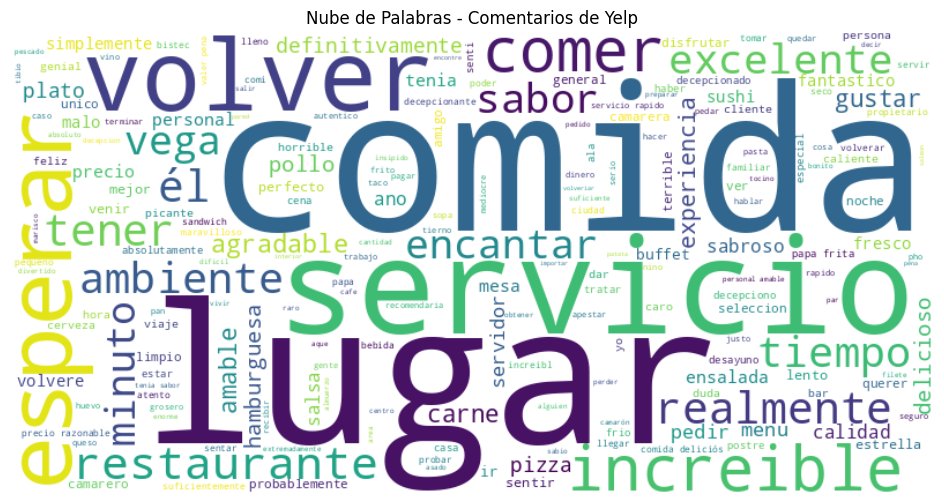

In [50]:
# Filtrar el DataFrame
df_yelp = df[df['Origen'] == 'yelp']

# Unir todos los lemas en un solo string (comentarios lematizados ya están en listas)
texto_yelp = ' '.join([' '.join(lemas) for lemas in df_yelp['Comentarios_lema']])

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_yelp)

# Mostrar la nube
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de Palabras - Comentarios de Yelp")
plt.show()


### Word cloud de Amazon

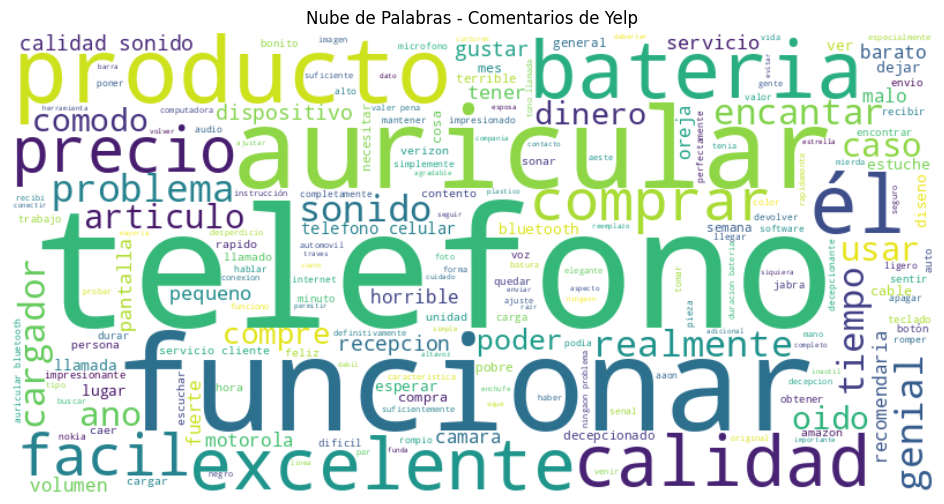

In [51]:
# Filtrar el DataFrame
df_amazon = df[df['Origen'] == 'amazon']

# Unir todos los lemas en un solo string (comentarios lematizados ya están en listas)
texto_amazon = ' '.join([' '.join(lemas) for lemas in df_amazon['Comentarios_lema']])

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_amazon)

# Mostrar la nube
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de Palabras - Comentarios de Yelp")
plt.show()


## Conteo de Palabras mas comunes

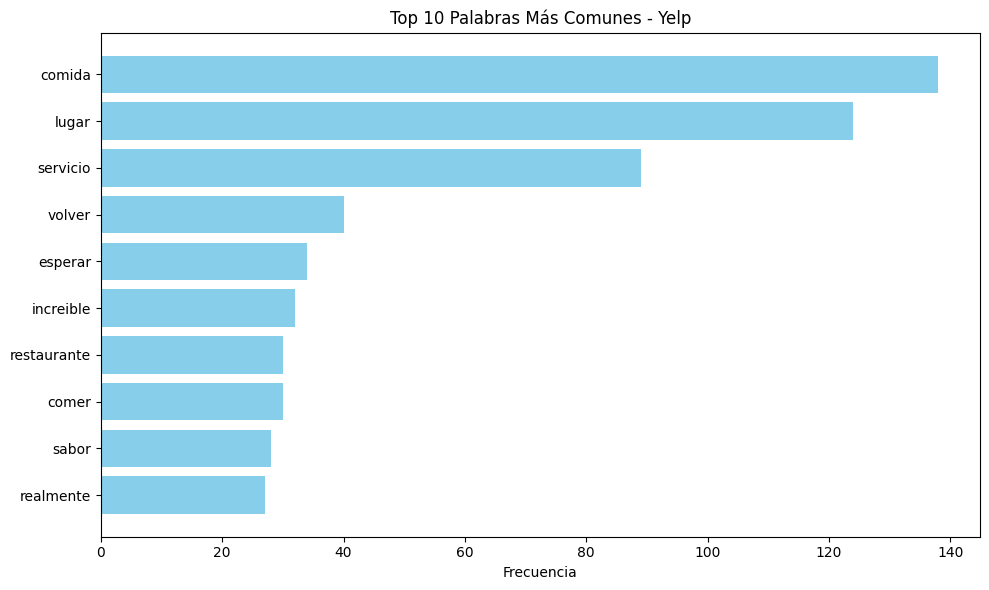

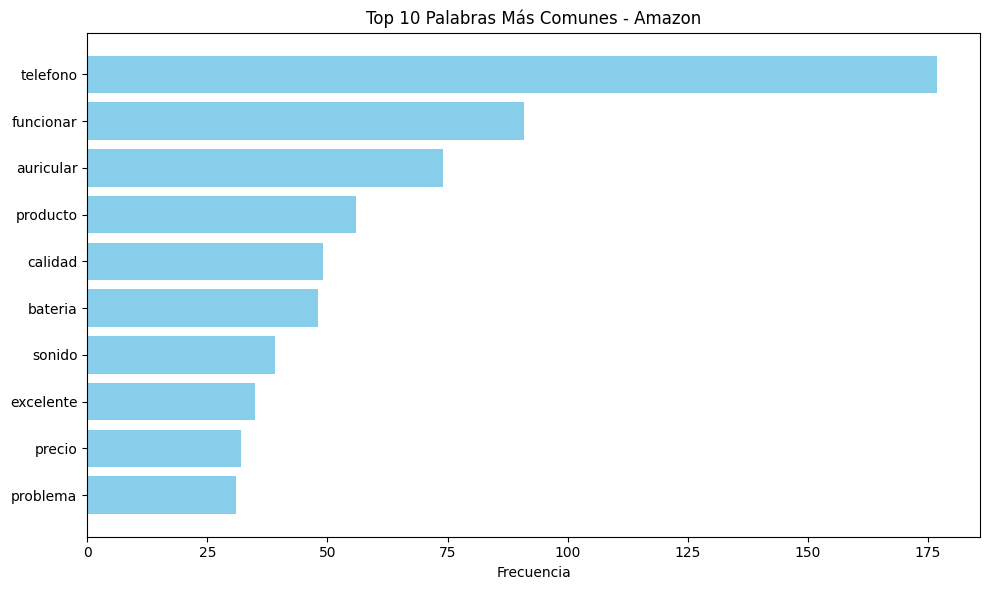

In [52]:
def graficar_palabras_comunes(df, origen, top_n=10):
    # Filtrar y aplanar los lemas
    lemas = [lema for lemas in df[df['Origen'] == origen]['Comentarios_lema'] for lema in lemas]
    conteo = Counter(lemas).most_common(top_n)

    # Separar palabras y frecuencias
    palabras, frecuencias = zip(*conteo)

    # Crear gráfico
    plt.figure(figsize=(10, 6))
    plt.barh(palabras, frecuencias, color='skyblue')
    plt.xlabel('Frecuencia')
    plt.title(f'Top {top_n} Palabras Más Comunes - {origen.capitalize()}')
    plt.gca().invert_yaxis()  # Poner la palabra más común arriba
    plt.tight_layout()
    plt.show()

# Graficar para Yelp
graficar_palabras_comunes(df, 'yelp')

# Graficar para Amazon
graficar_palabras_comunes(df, 'amazon')


## Bigramas + WordCloud

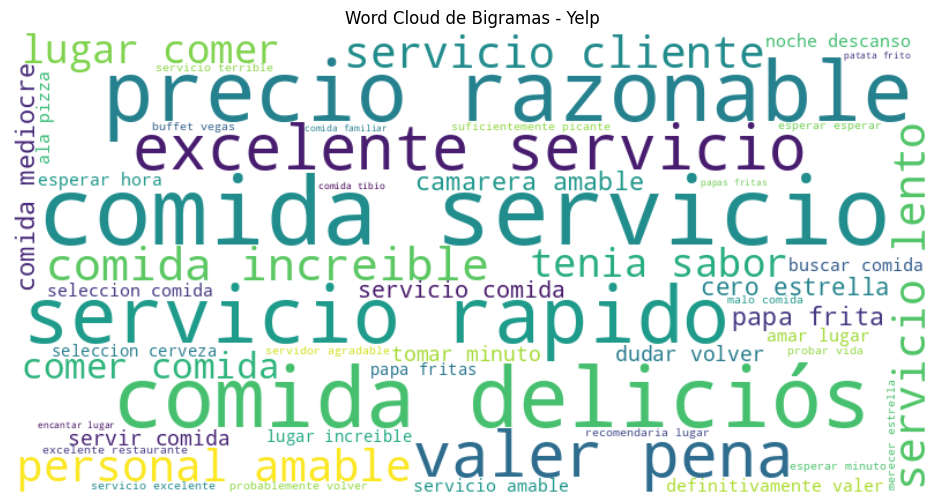

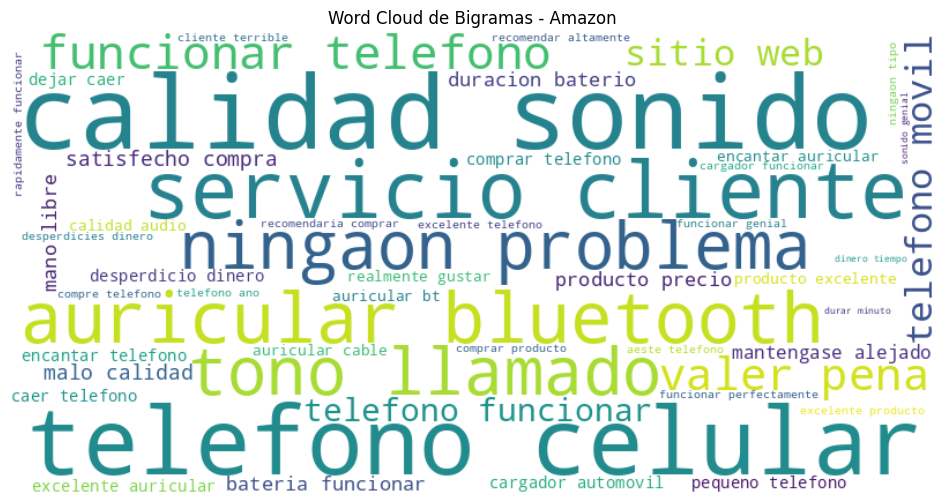

In [53]:
def generar_bigramas_spacy(df, origen, top_n=50):
    """
    Genera bigramas usando spaCy a partir de la columna 'Comentarios_Lema', sin stopwords.
    Luego genera una nube de palabras.
    """
    # Filtrar los comentarios por 'origen' (por ejemplo, 'yelp' o 'amazon')
    comentarios = df[df['Origen'] == origen]['Comentarios_lema']

    # Generar bigramas
    bigramas = []
    for comentario in comentarios:
        # Crear un Doc de spaCy a partir de la lista de lemas (de la columna 'Comentarios_Lema')
        doc = nlp(' '.join(comentario))  # Unimos la lista de lemas y lo procesamos con spaCy
        # Extraer bigramas
        for i in range(len(doc) - 1):
            if not doc[i].is_stop and not doc[i+1].is_stop:  # Asegurarse de que no sean stopwords
                bigramas.append((doc[i].lemma_, doc[i+1].lemma_))

    # Contar los bigramas más comunes
    conteo_bigramas = Counter(bigramas).most_common(top_n)

    # Convertir los bigramas a formato texto "palabra1 palabra2"
    bigramas_texto = {' '.join(bigrama): freq for bigrama, freq in conteo_bigramas}

    # Generar la nube de palabras de los bigramas
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigramas_texto)

    # Mostrar la nube
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud de Bigramas - {origen.capitalize()}")
    plt.show()

# Generar la nube de bigramas para Yelp y Amazon
generar_bigramas_spacy(df, 'yelp')
generar_bigramas_spacy(df, 'amazon')


## 🚀 Análisis de sentimiento en español con pysentimiento

###Procesamiento del sentimiento con los comentarios sin procesar.

In [ ]:
from pysentimiento import create_analyzer

# Crear analizador de sentimientos
analyzer = create_analyzer(task="sentiment", lang="es")

# Aplicar a una columna de texto
df['Sentimiento'] = df['Comentarios'].apply(lambda x: analyzer.predict(x).output)
# Sentimiento solo guarda lo predicho (POS, NEU o NEG)

df['Probabilidad'] = df['Comentarios'].apply(lambda x: analyzer.predict(x).probas)
#Ese diccionario contiene la probabilidad de cada clase: positivo, neutro, negativo Ejemplo: {'POS': 0.84, 'NEU': 0.10, 'NEG': 0.06}.



### 📊  Gráfico de barras de frecuencia de sentimientos


### Análisis de sentimientos con todos los datos de yelp y Amazon juntos.

In [ ]:
sns.countplot(data=df, x='Sentimiento', order=['POS', 'NEU', 'NEG'], palette='pastel')
plt.title('Distribución de Sentimientos')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de Comentarios')
plt.show()


In [ ]:
df['Sentimiento'].value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    labels=['Positivo', 'Neutro', 'Negativo'],
    colors=['lightgreen', 'lightblue', 'salmon']
)
plt.title('Distribución porcentual de Sentimientos')
plt.ylabel('')
plt.show()

### Distribución de sentiminetos de los comentarios de Yelp

In [ ]:
# Filtrar por origen "yelp"
df_yelp = df[df['Origen'] == 'yelp']

# Graficar los sentimientos de Yelp
sns.countplot(data=df_yelp, x='Sentimiento', order=['POS', 'NEU', 'NEG'], palette='pastel')
plt.title('Distribución de Sentimientos - Yelp')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de Comentarios')
plt.show()

### Distribución de sentiminetos de los comentarios de Amazon

In [ ]:
# Filtrar por origen "amazon"
df_amazon = df[df['Origen'] == 'amazon']

# Graficar los sentimientos de Yelp
sns.countplot(data=df_amazon, x='Sentimiento', order=['POS', 'NEU', 'NEG'], palette='pastel')
plt.title('Distribución de Sentimientos - Yelp')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de Comentarios')
plt.show()

### Distribución de sentimientos pero con los datos lematizados.

In [ ]:

resultados = [analyzer.predict(texto) for texto in df['Comentarios_lema'].apply(' '.join)]

# Aplicar a una columna de texto
df['Sentimiento_lema'] = [resultado.output for resultado in resultados]
df['Probabilidad_lema'] = [resultado.probas for resultado in resultados]

In [ ]:
# Filtrar por origen "yelp"
df_amazon = df[df['Origen'] == 'amazon']

# Graficar los sentimientos de Yelp
sns.countplot(data=df_amazon, x='Sentimiento', order=['POS', 'NEU', 'NEG'], palette='pastel')
plt.title('Distribución de Sentimientos - Yelp')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de Comentarios')
plt.show()

#### No se observan cambios respecto al análisis realizado con las frases sin lematizar.

### Análisis de Confianza para filtrar comentarios con baja certeza

In [ ]:
# Máxima probabilidad (nivel de certeza del modelo)
df['Confianza'] = df['Probabilidad'].apply(lambda x: max(x.values()))  # En este caso, de la lista {'POS': 0.84, 'NEU': 0.10, 'NEG': 0.06} sólo guarda 0.84 que es el valor mayor

In [ ]:
# Filtrar comentarios cuya confianza sea menor a 0.6
comentarios_baja_confianza = df[df['Confianza'] < 0.6]

# Ver los primeros resultados
comentarios_baja_confianza[['Comentarios', 'Sentimiento', 'Confianza']]

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='Confianza', bins=20, kde=True, color='skyblue')
plt.axvline(0.6, color='red', linestyle='--', label='Umbral 0.6')
plt.title('Distribución de Confianza del Sentimiento')
plt.xlabel('Confianza')
plt.ylabel('Cantidad de Comentarios')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Sentimiento', y='Confianza', order=['POS', 'NEU', 'NEG'], palette='pastel')
plt.title('Distribución de Confianza por Sentimiento')
plt.xlabel('Sentimiento')
plt.ylabel('Confianza')
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='Confianza', hue='Origen', bins=20, kde=True, palette='Set2')
plt.axvline(0.6, color='red', linestyle='--', label='Umbral 0.6')
plt.title('Distribución de Confianza por Origen')
plt.xlabel('Confianza')
plt.ylabel('Cantidad de Comentarios')
plt.legend()
plt.show()

In [ ]:
df_baja_confianza = df[df['Confianza'] < 0.6]


In [ ]:
 #Unir todos los lemas en un solo string (asumiendo que cada fila de 'Comentarios_lema' es una lista de palabras)
texto_baja_confianza = ' '.join([' '.join(lemas) for lemas in df_baja_confianza['Comentarios_lema']])

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='cool').generate(texto_baja_confianza)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de Palabras - Comentarios con Baja Confianza")
plt.show()